## import packages
Import all of necessary pakages we need, which include NunPy, Pandas, Matplotlib, Scikit-learn.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Loading Finance Dateset - Disney from YahooFinance
Use Pandas to read in the data and set the independent variable to be the Date. and see the first 5 rows data.

In [2]:
df = pd.read_csv('DIS.csv')
df = df.dropna()
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-27,135.770004,135.990005,134.190002,134.490005,134.490005,6013600
2019-08-28,134.059998,136.729996,133.520004,136.550003,136.550003,5950500
2019-08-29,138.119995,138.679993,137.419998,137.839996,137.839996,6532700
2019-08-30,138.289993,138.500000,136.759995,137.259995,137.259995,5622200
2019-09-03,136.369995,136.419998,135.059998,136.309998,136.309998,5989397


Let's take a look at how the prices looks like each day since the beginning up to this point with the date on the x-axis and the price on the y-axis.

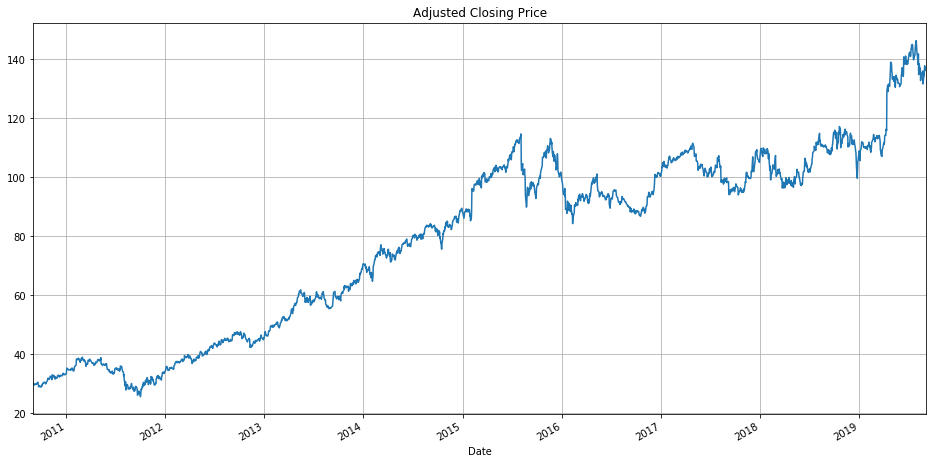

In [3]:
df['Adj Close'].plot(label='DIS', figsize=(16,8), title='Adjusted Closing Price', grid=True)

## Preprocessing & Cross Validation

In [4]:
window_size = 32
num_sample = len(df) - window_size
indices = np.arange(num_sample).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [5]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training sample

In [6]:
X = data[:,:-1]
y = data[:,-1]

## Training set & data set for test
We split 80% of the data to training set while 20% of the data to test set using below code.

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_sample)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

# Method #1 -  Ridge Regression

## Model Generation & Prediction

In [8]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

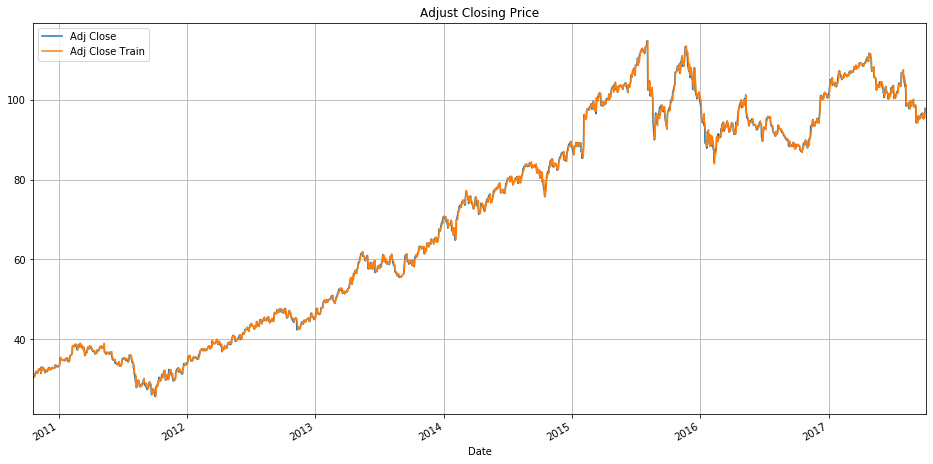

In [9]:
#Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'],axis=1,inplace=True)
df_ridge = df_ridge.iloc[window_size:int(num_sample*0.8)]
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='DIS',figsize=(16,8),title='Adjust Closing Price',grid=True)

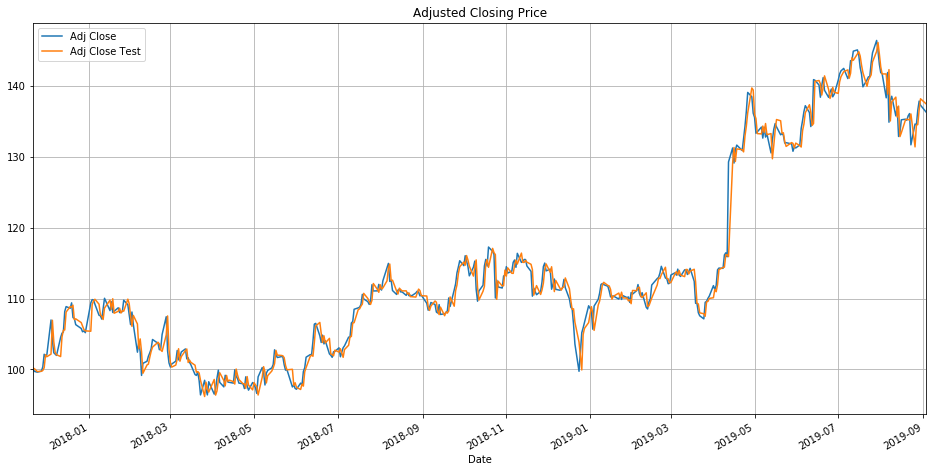

In [10]:
# test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:]
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='DIS', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Evaluation

In [11]:
ridge_model_score = ridge_model.score(X_test, y_test)
print('RidgeModel Score:', ridge_model_score)

RidgeModel Score: 0.9852993824971594


# Plotting the Prediction

In [12]:
forecast_out = 30
x_forecast = X_test[-forecast_out:]
ridge_model_forecast_prediction = ridge_model.predict(x_forecast)

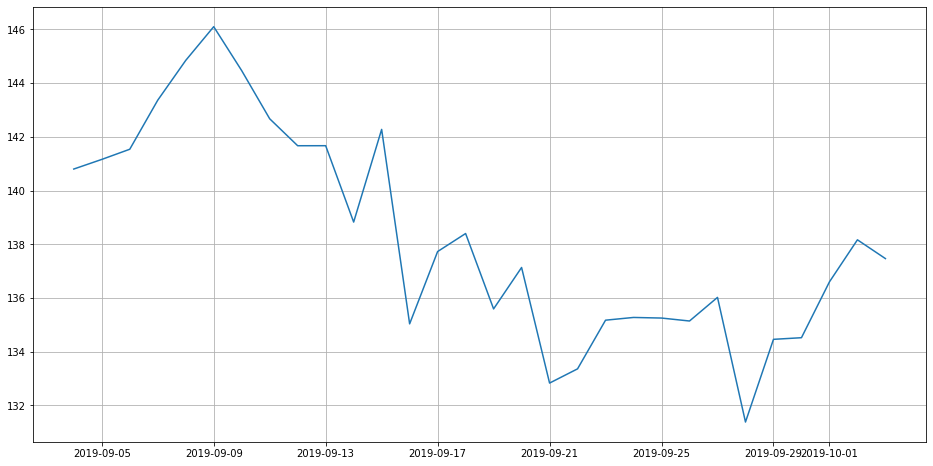

In [13]:
predicted_dates = []
recent_date = df.index.max()
for i in range(forecast_out):
    recent_date += timedelta(days=1)
    predicted_dates.append(recent_date)
    
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(predicted_dates, ridge_model_forecast_prediction, label='Ridge')

# Method #2 - Gradient Boosting Trees

## Model Generation & Prediction

In [14]:
# Model #2 - Gradient Boosting Trees
gb_model = LinearRegression()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

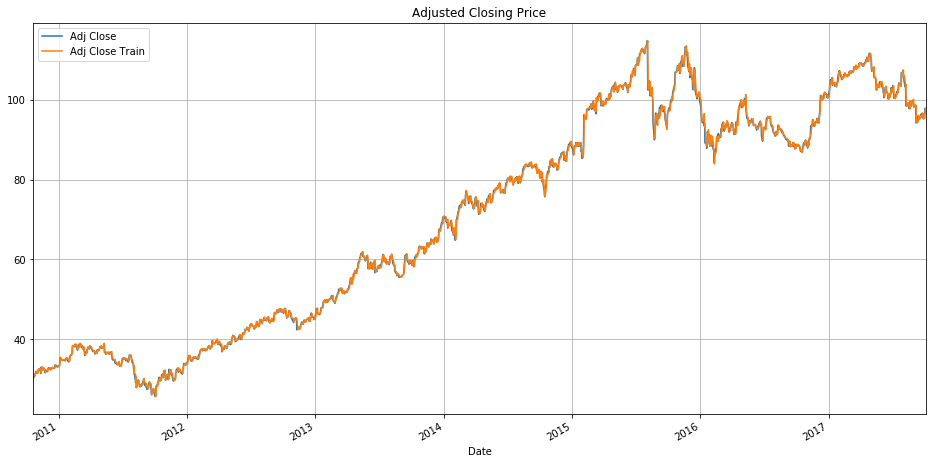

In [15]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] 
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='DIS', figsize=(16,8), title='Adjusted Closing Price', grid=True)

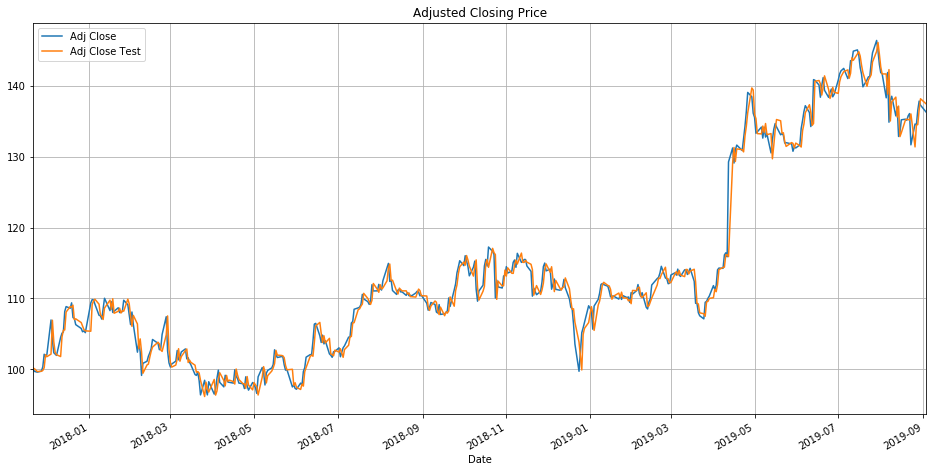

In [16]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] 
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='DIS', figsize=(16,8), title='Adjusted Closing Price', grid=True)

## Plotting the Prediction

In [17]:
gb_forecast = X_test[-forecast_out:]
gb_model_forecast_prediction = gb_model.predict(gb_forecast)

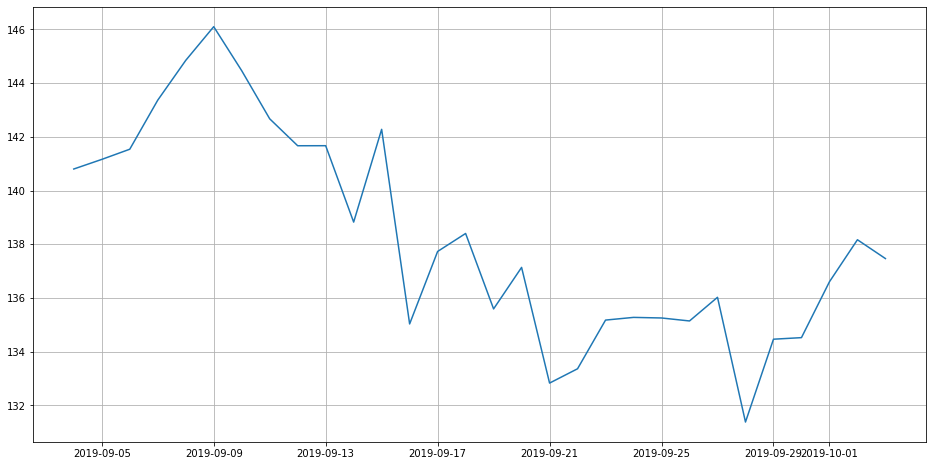

In [18]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(predicted_dates, gb_model_forecast_prediction, label='Ridge')

# Method #3 - Using neural networks with 1D convolutional and LSTM layers
The last method we'll use is a neural network based one using Keras / Tensorflow. We use a stack of Conv1D and LSTM layers, followed by Dense layers lastly followed by a linear layer to predict the stock price.

In [19]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

This is a technique to find the optimal learning rate for the neural network. Specifically we gradually increase the learning rate at each epoch, recording the loss for each then choosing the learning rate that has the smallest loss overall.

Also, neural networks learn better when the data is normalized so we will normalize the data to the $[-1,1]$ range by using Scikit-learn's MinMaxScaler. Therefore, we need to find apply this scaling on all of the price data, then decompose it into the training and test sets again.

In [20]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

We now try and find the optimal learning rate. If you're using Google Colab, this will take ~4 minutes.

In [21]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1785 samples, validate on 447 samples
Epoch 1/250
1785/1785 [==============================] - 4s 2ms/step - loss: 0.1070 - mean_absolute_error: 0.3793 - val_loss: 0.1060 - val_mean_absolute_error: 0.4144
Epoch 2/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.1070 - mean_absolute_error: 0.3793 - val_loss: 0.1060 - val_mean_absolute_error: 0.4144
Epoch 3/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.1070 - mean_absolute_error: 0.3793 - val_loss: 0.1060 - val_mean_absolute_error: 0.4144
Epoch 4/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.1070 - mean_absolute_error: 0.3793 - val_loss: 0.1060 - val_mean_absolute_error: 0.4144
Epoch 5/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.1070 - mean_absolute_error: 0.3793 - val_loss: 0.1060 - val_mean_absolute_error: 0.4144
Epoch 6/250
1785/1785 

1785/1785 [==============================] - 2s 1ms/step - loss: 0.1062 - mean_absolute_error: 0.3782 - val_loss: 0.1063 - val_mean_absolute_error: 0.4152
Epoch 46/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.1061 - mean_absolute_error: 0.3781 - val_loss: 0.1063 - val_mean_absolute_error: 0.4153
Epoch 47/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.1060 - mean_absolute_error: 0.3780 - val_loss: 0.1064 - val_mean_absolute_error: 0.4154
Epoch 48/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.1059 - mean_absolute_error: 0.3778 - val_loss: 0.1064 - val_mean_absolute_error: 0.4155
Epoch 49/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.1057 - mean_absolute_error: 0.3776 - val_loss: 0.1064 - val_mean_absolute_error: 0.4156
Epoch 50/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.1056 - mean_absolute_error: 0.3774 - val_loss: 0.1065 - val_mean_absolute_error: 0.4158
Epoch

Epoch 94/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0236 - mean_absolute_error: 0.1965 - val_loss: 0.0696 - val_mean_absolute_error: 0.3517
Epoch 95/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0200 - mean_absolute_error: 0.1804 - val_loss: 0.0602 - val_mean_absolute_error: 0.3264
Epoch 96/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0164 - mean_absolute_error: 0.1629 - val_loss: 0.0503 - val_mean_absolute_error: 0.2969
Epoch 97/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0131 - mean_absolute_error: 0.1447 - val_loss: 0.0404 - val_mean_absolute_error: 0.2638
Epoch 98/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0100 - mean_absolute_error: 0.1259 - val_loss: 0.0310 - val_mean_absolute_error: 0.2283
Epoch 99/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.1065 - val_loss: 0.0226 - val_mean_absolute_error:

1785/1785 [==============================] - 2s 1ms/step - loss: 7.6925e-04 - mean_absolute_error: 0.0294 - val_loss: 0.0058 - val_mean_absolute_error: 0.0768
Epoch 143/250
1785/1785 [==============================] - 2s 1ms/step - loss: 7.5960e-04 - mean_absolute_error: 0.0290 - val_loss: 0.0064 - val_mean_absolute_error: 0.0822
Epoch 144/250
1785/1785 [==============================] - 2s 1ms/step - loss: 7.6966e-04 - mean_absolute_error: 0.0298 - val_loss: 0.0064 - val_mean_absolute_error: 0.0811
Epoch 145/250
1785/1785 [==============================] - 2s 1ms/step - loss: 7.3822e-04 - mean_absolute_error: 0.0290 - val_loss: 0.0058 - val_mean_absolute_error: 0.0761
Epoch 146/250
1785/1785 [==============================] - 2s 1ms/step - loss: 7.1750e-04 - mean_absolute_error: 0.0287 - val_loss: 0.0053 - val_mean_absolute_error: 0.0719
Epoch 147/250
1785/1785 [==============================] - 2s 1ms/step - loss: 8.1753e-04 - mean_absolute_error: 0.0314 - val_loss: 0.0057 - val_mean

Epoch 189/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4404.7283 - mean_absolute_error: 4405.2281 - val_loss: 3811.2930 - val_mean_absolute_error: 3811.7937
Epoch 190/250
1785/1785 [==============================] - 2s 1ms/step - loss: 3762.4933 - mean_absolute_error: 3762.9934 - val_loss: 3609.8152 - val_mean_absolute_error: 3610.3156
Epoch 191/250
1785/1785 [==============================] - 2s 1ms/step - loss: 3096.5675 - mean_absolute_error: 3097.0673 - val_loss: 1937.6349 - val_mean_absolute_error: 1938.1349
Epoch 192/250
1785/1785 [==============================] - 2s 1ms/step - loss: 1266.3839 - mean_absolute_error: 1266.8837 - val_loss: 1724.4892 - val_mean_absolute_error: 1724.9890
Epoch 193/250
1785/1785 [==============================] - 2s 1ms/step - loss: 1841.9835 - mean_absolute_error: 1842.4835 - val_loss: 6427.9961 - val_mean_absolute_error: 6428.4977
Epoch 194/250
1785/1785 [==============================] - 2s 1ms/step - loss: 5743.2718 - mean

1785/1785 [==============================] - 2s 1ms/step - loss: 459655.1564 - mean_absolute_error: 459655.6226 - val_loss: 225108.3041 - val_mean_absolute_error: 225108.8352
Epoch 234/250
1785/1785 [==============================] - 2s 1ms/step - loss: 430818.3151 - mean_absolute_error: 430818.7782 - val_loss: 797497.6704 - val_mean_absolute_error: 797498.0449
Epoch 235/250
1785/1785 [==============================] - 2s 1ms/step - loss: 343534.2470 - mean_absolute_error: 343534.7331 - val_loss: 225504.4328 - val_mean_absolute_error: 225504.8947
Epoch 236/250
1785/1785 [==============================] - 2s 1ms/step - loss: 361207.8920 - mean_absolute_error: 361208.4087 - val_loss: 645675.4636 - val_mean_absolute_error: 645675.9284
Epoch 237/250
1785/1785 [==============================] - 2s 1ms/step - loss: 688145.1274 - mean_absolute_error: 688145.5910 - val_loss: 384057.0534 - val_mean_absolute_error: 384057.6426
Epoch 238/250
1785/1785 [==============================] - 2s 1ms/ste

Let's plot the loss for the testing data versus the learning rate. We can see that it explodes past a learning rate of 1, so let's focus our window to before this point.

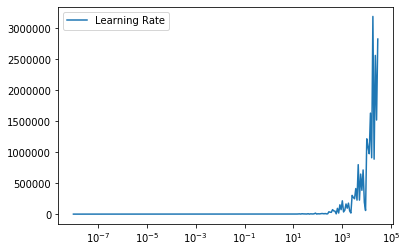

In [22]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

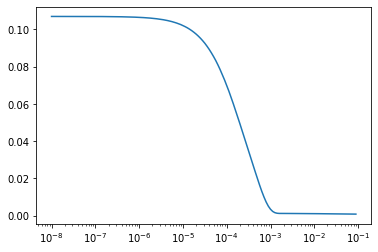

In [23]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

It looks like the learning rate of 0.1 seems to work the best. Let's use that learning rate and train the network this time for real. Once we train the network, let's predict the prices for the training and test data.

In [24]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 1785 samples, validate on 447 samples
Epoch 1/250
1785/1785 [==============================] - 4s 2ms/step - loss: 0.0517 - mean_absolute_error: 0.2597 - val_loss: 0.0042 - val_mean_absolute_error: 0.0773
Epoch 2/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0129 - mean_absolute_error: 0.1318 - val_loss: 0.0113 - val_mean_absolute_error: 0.1361
Epoch 3/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.1018 - val_loss: 0.0267 - val_mean_absolute_error: 0.2033
Epoch 4/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0043 - mean_absolute_error: 0.0763 - val_loss: 0.0055 - val_mean_absolute_error: 0.0876
Epoch 5/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0024 - mean_absolute_error: 0.0563 - val_loss: 0.0122 - val_mean_absolute_error: 0.1116
Epoch 6/250
1785/1785 [==============================] - 2s 1ms/step - loss: 0.0015 - mean_absolute_error: 0.0430 - va

1785/1785 [==============================] - 2s 1ms/step - loss: 5.8596e-04 - mean_absolute_error: 0.0253 - val_loss: 0.0056 - val_mean_absolute_error: 0.0758
Epoch 49/250
1785/1785 [==============================] - 2s 1ms/step - loss: 5.8220e-04 - mean_absolute_error: 0.0253 - val_loss: 0.0051 - val_mean_absolute_error: 0.0716
Epoch 50/250
1785/1785 [==============================] - 2s 1ms/step - loss: 5.7545e-04 - mean_absolute_error: 0.0252 - val_loss: 0.0045 - val_mean_absolute_error: 0.0663
Epoch 51/250
1785/1785 [==============================] - 2s 1ms/step - loss: 5.7164e-04 - mean_absolute_error: 0.0251 - val_loss: 0.0054 - val_mean_absolute_error: 0.0746
Epoch 52/250
1785/1785 [==============================] - 2s 1ms/step - loss: 5.8524e-04 - mean_absolute_error: 0.0256 - val_loss: 0.0047 - val_mean_absolute_error: 0.0685
Epoch 53/250
1785/1785 [==============================] - 2s 1ms/step - loss: 5.7350e-04 - mean_absolute_error: 0.0255 - val_loss: 0.0046 - val_mean_abso

Epoch 96/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.7553e-04 - mean_absolute_error: 0.0226 - val_loss: 0.0036 - val_mean_absolute_error: 0.0621
Epoch 97/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.7731e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0034 - val_mean_absolute_error: 0.0597
Epoch 98/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.6721e-04 - mean_absolute_error: 0.0225 - val_loss: 0.0032 - val_mean_absolute_error: 0.0573
Epoch 99/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.7158e-04 - mean_absolute_error: 0.0227 - val_loss: 0.0034 - val_mean_absolute_error: 0.0597
Epoch 100/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.7686e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0031 - val_mean_absolute_error: 0.0564
Epoch 101/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.6773e-04 - mean_absolute_error: 0.0226 - val_loss: 0.0029 

1785/1785 [==============================] - 2s 1ms/step - loss: 4.3094e-04 - mean_absolute_error: 0.0218 - val_loss: 0.0029 - val_mean_absolute_error: 0.0549
Epoch 144/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.4393e-04 - mean_absolute_error: 0.0224 - val_loss: 0.0034 - val_mean_absolute_error: 0.0601
Epoch 145/250
1785/1785 [==============================] - 3s 1ms/step - loss: 4.4463e-04 - mean_absolute_error: 0.0224 - val_loss: 0.0028 - val_mean_absolute_error: 0.0545
Epoch 146/250
1785/1785 [==============================] - 3s 1ms/step - loss: 4.3748e-04 - mean_absolute_error: 0.0221 - val_loss: 0.0028 - val_mean_absolute_error: 0.0540
Epoch 147/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.2841e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0028 - val_mean_absolute_error: 0.0544
Epoch 148/250
1785/1785 [==============================] - 3s 1ms/step - loss: 4.2642e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0027 - val_mean

1785/1785 [==============================] - 2s 1ms/step - loss: 4.0128e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0027 - val_mean_absolute_error: 0.0536
Epoch 191/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.1786e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0028 - val_mean_absolute_error: 0.0540
Epoch 192/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.0548e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0032 - val_mean_absolute_error: 0.0588
Epoch 193/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.0490e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0030 - val_mean_absolute_error: 0.0565
Epoch 194/250
1785/1785 [==============================] - 2s 1ms/step - loss: 4.0341e-04 - mean_absolute_error: 0.0212 - val_loss: 0.0031 - val_mean_absolute_error: 0.0572
Epoch 195/250
1785/1785 [==============================] - 2s 1ms/step - loss: 3.9863e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0029 - val_mean

1785/1785 [==============================] - 2s 1ms/step - loss: 4.0572e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0032 - val_mean_absolute_error: 0.0591
Epoch 238/250
1785/1785 [==============================] - 2s 1ms/step - loss: 3.8861e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0029 - val_mean_absolute_error: 0.0559
Epoch 239/250
1785/1785 [==============================] - 2s 1ms/step - loss: 3.7747e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0028 - val_mean_absolute_error: 0.0538
Epoch 240/250
1785/1785 [==============================] - 2s 1ms/step - loss: 3.7501e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0027 - val_mean_absolute_error: 0.0537
Epoch 241/250
1785/1785 [==============================] - 2s 1ms/step - loss: 3.8202e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0032 - val_mean_absolute_error: 0.0589
Epoch 242/250
1785/1785 [==============================] - 2s 1ms/step - loss: 3.8142e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0032 - val_mean

Once we predict the values, we also must reverse the normalization so that we can plot the predictions in the same scale as the original values.

In [25]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

Let's now plot what the training and test predictions look like and compare witht he original values.

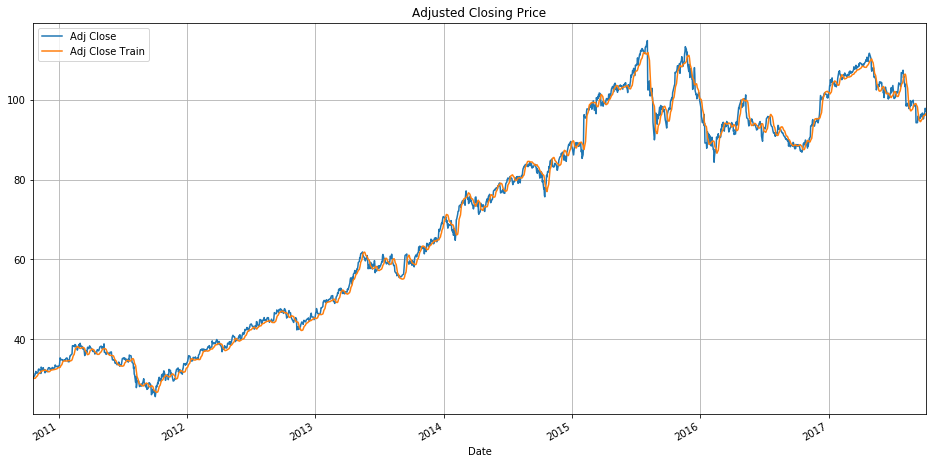

In [26]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='DIS', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Again, quite accurate... and now for the test data.

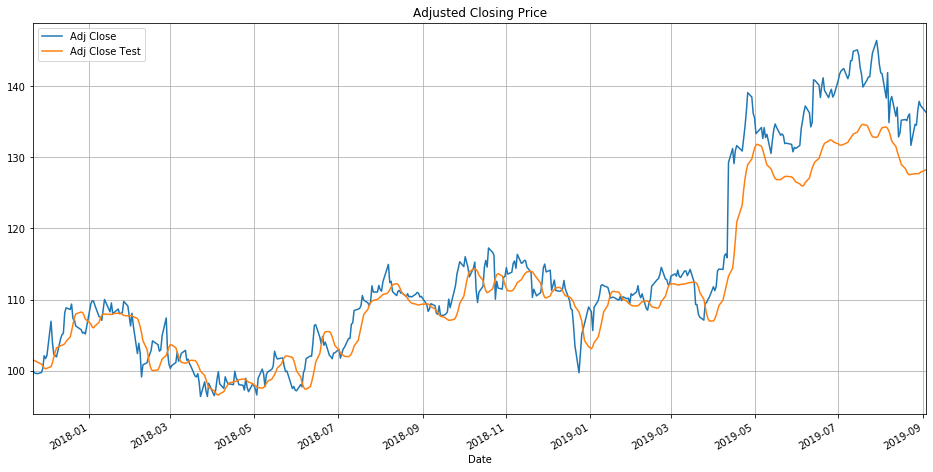

In [27]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='DIS', figsize=(16,8), title='Adjusted Closing Price', grid=True)

I have more confidence in the neural network approach as it seems to indicate would the trend would be like when the data is noise free. We can also see a more smoother transition between points of high curvature.

Finally to see how everything performs, let's plot all of the methods together for both the training and testing data.

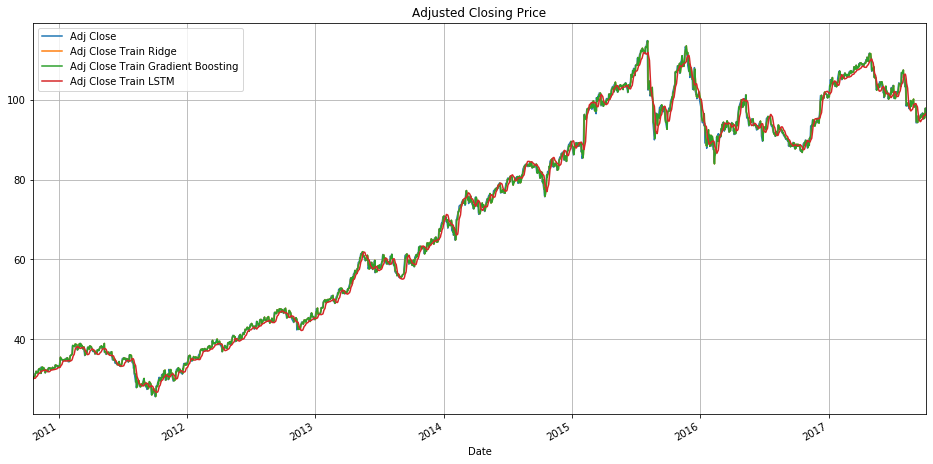

In [28]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train LinearRegression'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Cool. They all more or less follow the same trend... and now for the testing data.

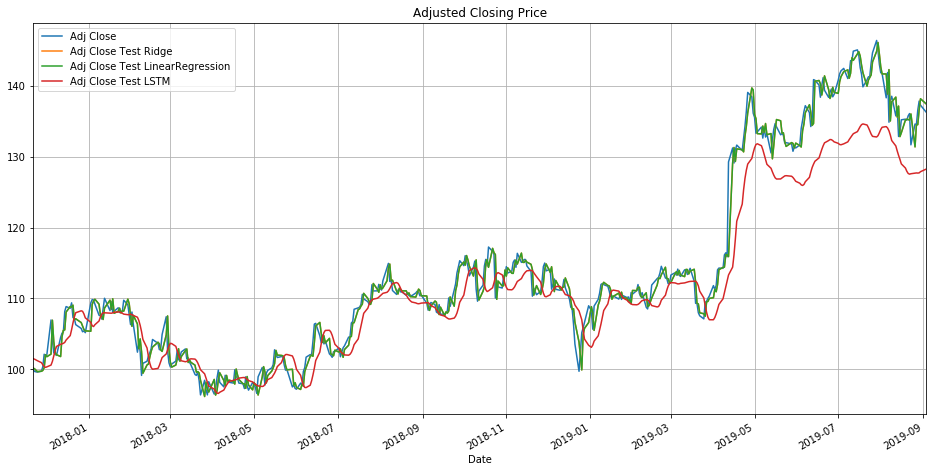

In [30]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test LinearRegression'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='DIS', figsize=(16,8), title='Adjusted Closing Price', grid=True)